# Evaluating the spaCy NER model

In [76]:
import json
from pathlib import Path

import spacy
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from spacy.tokens import DocBin

In [77]:
TRAINED_MODEL_DIR = Path("./trained_models/")
RAW_DATA_FILE = Path("./../raw_data/train.json")

In [78]:
# Prepare test data
with RAW_DATA_FILE.open("r", encoding="utf-8") as f:
    data = json.load(f)
_, test_data = train_test_split(data[:1000], test_size=0.2, random_state=42)

# Create a blank model for the English language
nlp = spacy.blank("en")

TEST_DATA = DocBin()
for document in test_data:
    text = ""
    current_pos = 0
    entities = []
    current_entity = None

    # Rebuild the text from tokens and whitespace
    for token, has_space, label in zip(
        document["tokens"], document["trailing_whitespace"], document["labels"]
    ):
        # Calculate the start and end positions of the token
        start = current_pos
        end = start + len(token)
        text += token
        current_pos += len(token)

        if has_space:
            text += " "
            current_pos += 1

        # Check label to update entity annotations
        if label.startswith("B-"):
            # Save the previous entity if any
            if current_entity:
                entities.append(current_entity)

            # Extract label type without BIO prefix
            label_type = label.split("-", 1)[1]
            current_entity = (start, end, label_type)

        elif label.startswith("I-") and current_entity:
            # Update the end of the current entity if label is continuation
            _, _, label_type = current_entity
            current_entity = (current_entity[0], end, label_type)

        else:
            # Save the previous entity if it's the end of an entity
            if current_entity:
                entities.append(current_entity)
                current_entity = None

    # Ensure the last entity is added if the document ends with an entity
    if current_entity:
        entities.append(current_entity)

    # Create a Doc object and set its entities
    doc = nlp.make_doc(text)
    ents = [
        doc.char_span(start, end, label=label)
        for start, end, label in entities
        if doc.char_span(start, end, label=label) is not None
    ]
    doc.ents = ents

    # Add processed document to DocBin
    TEST_DATA.add(doc)

In [79]:
def predict_model(model: Path, test_data: DocBin):
    """Predicts entities using the trained model and returns the actual and predicted entities."""
    # Load the trained model
    print(f'Loading model "{model}"...')
    nlp = spacy.load(model)

    # Load the test docs
    test_docs = list(test_data.get_docs(nlp.vocab))

    entities = {"actual": [], "predicted": []}

    print("Predicting entities...")
    for doc in test_docs:
        # Gather the actual and predicted entities
        actual_entities = [(ent.start, ent.end, ent.label_) for ent in doc.ents]
        predicted_entities = [
            (ent.start, ent.end, ent.label_) for ent in nlp(doc.text).ents
        ]

        actual_index = 0
        predicted_index = 0

        # print(f"\nTOTAL A: {len(actual_entities)}, P: {len(predicted_entities)}")
        while actual_index < len(actual_entities) and predicted_index < len(
            predicted_entities
        ):
            # print(f"Actual: {actual_index}, Predicted: {predicted_index}")
            actual_start, actual_end, actual_label = actual_entities[actual_index]
            predicted_start, predicted_end, predicted_label = predicted_entities[
                predicted_index
            ]

            # False negative
            if actual_start < predicted_start:
                # print("False negative")
                entities["actual"].append(actual_label)
                entities["predicted"].append("-")
                actual_index += 1
                continue

            # False positive
            if actual_start > predicted_start:
                # print("False positive")
                entities["actual"].append("-")
                entities["predicted"].append(predicted_label)
                predicted_index += 1
                continue

            # if actual_start == predicted_start:
            # True positive
            if actual_end == predicted_end:
                # print("True positive")
                entities["actual"].append(actual_label)
                entities["predicted"].append(predicted_label)
                actual_index += 1
                predicted_index += 1
                continue

            # if actual_start == predicted_start:
            # actual entity is shorter than predicted entity
            if actual_end < predicted_end:
                # print("Actual < predicted")
                entities["actual"].append(actual_label)
                entities["predicted"].append(predicted_label)
                actual_index += 1
                predicted_index += 1
                # Keep adding actual entities until we reach the end of the predicted entity
                while actual_end < predicted_end:
                    # print(f"Adding actual entity {actual_index}...")
                    actual_index += 1
                    if actual_index < len(actual_entities):
                        actual_start, actual_end, actual_label = actual_entities[
                            actual_index
                        ]
                    else:
                        break
                continue

            # if actual_start == predicted_start:
            # actual entity is longer than predicted entity
            if actual_end > predicted_end:
                # print("Actual > predicted")
                entities["actual"].append(actual_label)
                entities["predicted"].append(predicted_label)
                actual_index += 1
                predicted_index += 1
                # Keep adding predicted entities until we reach the end of the actual entity
                while actual_end > predicted_end:
                    # print(f"Adding predicted entity {predicted_index}...")
                    predicted_index += 1
                    if predicted_index < len(predicted_entities):
                        predicted_start, predicted_end, predicted_label = (
                            predicted_entities[predicted_index]
                        )
                    else:
                        break
                continue

    print("Done predicting entities...")
    return entities


In [80]:
def evaluate_entities(entities: dict[str, list]):
    """Evaluates the actual and predicted entities and returns the classification report and confusion matrix."""
    print("Evaluating entities...")
    print(classification_report(entities["actual"], entities["predicted"]))

    return classification_report

In [88]:
def plot_confusion_matrix(entities: dict[str, list]):
    """Plots the confusion matrix."""
    # Display the labels used in the confusion matrix
    labels = list(set(entities["actual"]))
    print(f'Labels: {labels}')

    print("Plotting confusion matrix...")
    cm = confusion_matrix(entities["actual"], entities["predicted"])
    ConfusionMatrixDisplay(cm).plot()


SyntaxError: f-string expression part cannot include a backslash (3077184622.py, line 5)

In [82]:
prediction = predict_model(TRAINED_MODEL_DIR / "model-B-06/", TEST_DATA)
for k, lst in prediction.items():
    print(k, len(lst))


Loading model "trained_models\model-B-06"...
Predicting entities...
Done predicting entities...
actual 159
predicted 159


Evaluating entities...
              precision    recall  f1-score   support

           -       0.00      0.00      0.00        13
       EMAIL       1.00      1.00      1.00         2
      ID_NUM       1.00      0.64      0.78        11
NAME_STUDENT       0.90      0.94      0.92       125
URL_PERSONAL       1.00      0.88      0.93         8

    accuracy                           0.84       159
   macro avg       0.78      0.69      0.73       159
weighted avg       0.84      0.84      0.83       159

Labels: ['-', 'URL_PERSONAL', 'NAME_STUDENT', 'EMAIL', 'ID_NUM']
Plotting confusion matrix...


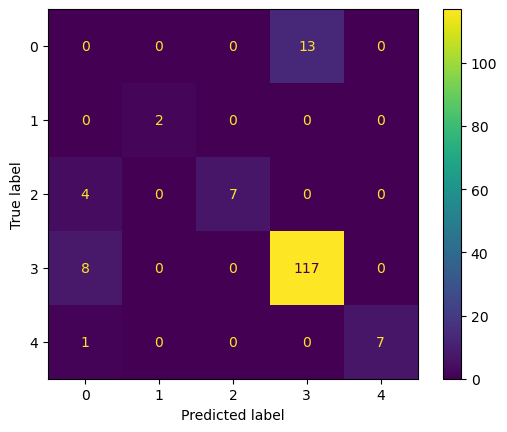

In [85]:
score = evaluate_entities(prediction)
plot_confusion_matrix(prediction)


In [84]:
# all_models = list(TRAINED_MODEL_DIR.glob("*/"))
# all_model_results = {}

# for model in all_models:
#     prediction = predict_model(model, TEST_DATA)
#     for k, lst in prediction.items():
#         print(k, len(lst))
#     score = evaluate_entities(prediction)
#     all_model_results[model] = {"score": score, "entities": prediction}